In [1]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
visit_df=pd.read_csv('../pcms_hackathon_data/train/visit.csv')

In [3]:
visit_df.columns

Index(['visit_id', 'visit_type', 'patient_id', 'visit_start_dt',
       'visit_end_dt', 'follow_up_dt', 'prmry_proc_nm', 'prncpl_diag_nm',
       'readmsn_ind'],
      dtype='object')

In [4]:
visit_df.head(3)

,visit_id,visit_type,patient_id,visit_start_dt,visit_end_dt,follow_up_dt,prmry_proc_nm,prncpl_diag_nm,readmsn_ind
0,7698,URGENT CARE,80,2023-12-23,2023-12-23,8888-12-31,NaN,"Acute upper respiratory infection, unspecified",f
1,7699,URGENT CARE,80,2024-02-18,2024-02-18,8888-12-31,NaN,"Acute pharyngitis, unspecified",f
2,7700,URGENT CARE,80,2024-03-10,2024-03-10,8888-12-31,NaN,"Acute pharyngitis, unspecified",f


In [5]:
visit_df.shape

(6188, 9)

In [6]:
visit_df.isnull().sum()

visit_id             0
visit_type           0
patient_id           0
visit_start_dt       0
visit_end_dt         0
follow_up_dt         0
prmry_proc_nm     6188
prncpl_diag_nm       0
readmsn_ind          0
dtype: int64

In [7]:
visit_df.drop(columns=['prmry_proc_nm'], inplace=True)

In [8]:
visit_df.visit_type.value_counts()

visit_type
URGENT CARE    3328
ER             2431
INPATIENT       429
Name: count, dtype: int64

In [9]:
visit_df.patient_id.value_counts()

patient_id
52610    21
72722    17
23382    15
79145    14
32368    13
         ..
31474     1
31539     1
1498      1
1536      1
161       1
Name: count, Length: 3087, dtype: int64

In [10]:
visit_df.readmsn_ind.value_counts()

readmsn_ind
f    6153
t      35
Name: count, dtype: int64

In [11]:
visit_df.follow_up_dt.value_counts()

follow_up_dt
8888-12-31    5882
2024-09-25       5
2024-04-19       4
2024-02-28       4
2024-08-15       3
              ... 
2024-05-17       1
2024-03-18       1
2024-10-09       1
2023-10-11       1
2023-05-19       1
Name: count, Length: 214, dtype: int64

In [12]:
visit_df['visit_start_dt'] = pd.to_datetime(visit_df['visit_start_dt'], format='%Y-%m-%d', errors='coerce')
visit_df['visit_end_dt'] = pd.to_datetime(visit_df['visit_end_dt'], format='%Y-%m-%d', errors='coerce')
visit_df['follow_up_dt'] = pd.to_datetime(visit_df['follow_up_dt'], format='%Y-%m-%d', errors='coerce')


In [13]:
visit_df['readmsn_ind'] = (visit_df['readmsn_ind'] == 't').astype(int)

In [14]:
visit_df.loc[visit_df['follow_up_dt'].dt.year == 8888, 'follow_up_dt'] = pd.NaT


In [15]:
visit_df['visit_duration_days'] = (visit_df['visit_end_dt'] - visit_df['visit_start_dt']).dt.days


In [16]:
visit_df['has_followup'] = visit_df['follow_up_dt'].notna().astype(int)


In [17]:
visit_features = visit_df.groupby('patient_id').agg({
    'visit_id': 'count',                     
    'visit_type': 'nunique',                  
    'prncpl_diag_nm': 'nunique',              
    'readmsn_ind': 'sum',                    
    'has_followup': 'sum',                    
    'visit_duration_days': 'mean'             
}).reset_index()

visit_features.rename(columns={
    'visit_id': 'num_visits',
    'visit_type': 'visit_type_diversity',
    'prncpl_diag_nm': 'unique_diagnoses',
    'readmsn_ind': 'num_readmissions',
    'has_followup': 'num_followups',
    'visit_duration_days': 'avg_visit_duration'
}, inplace=True)


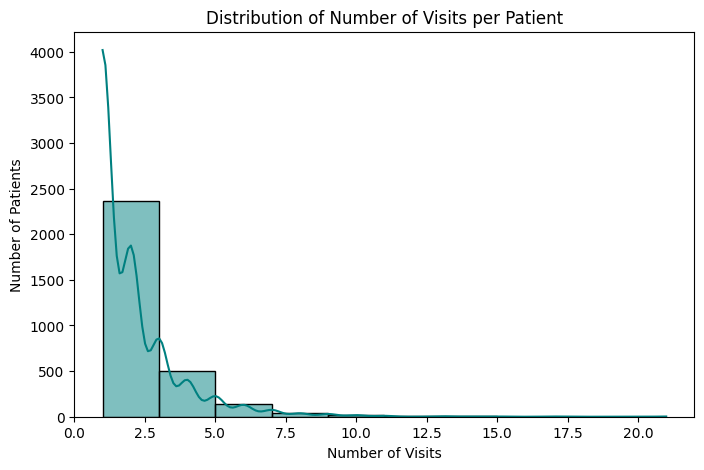

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(visit_features['num_visits'], bins=10, kde=True, color='teal')
plt.title('Distribution of Number of Visits per Patient')
plt.xlabel('Number of Visits')
plt.ylabel('Number of Patients')
plt.show()


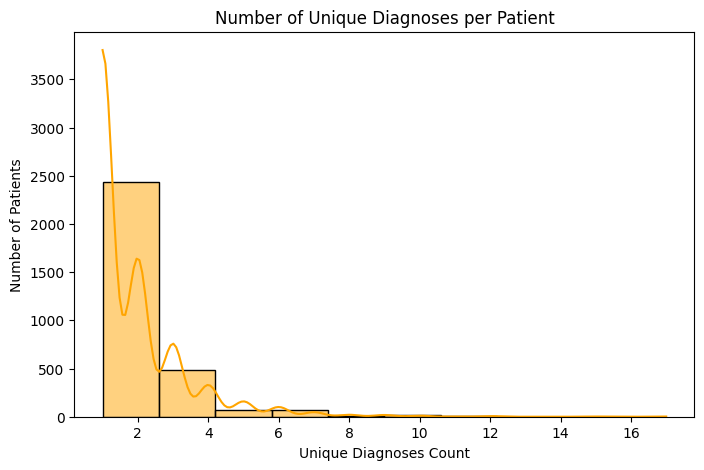

In [19]:
plt.figure(figsize=(8,5))
sns.histplot(visit_features['unique_diagnoses'], bins=10, kde=True, color='orange')
plt.title('Number of Unique Diagnoses per Patient')
plt.xlabel('Unique Diagnoses Count')
plt.ylabel('Number of Patients')
plt.show()


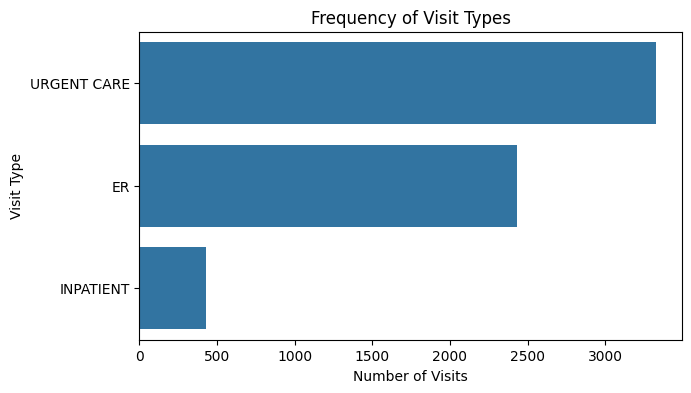

In [20]:
plt.figure(figsize=(7,4))
sns.countplot(y='visit_type', data=visit_df, order=visit_df['visit_type'].value_counts().index)
plt.title('Frequency of Visit Types')
plt.xlabel('Number of Visits')
plt.ylabel('Visit Type')
plt.show()


In [21]:
visit_df.readmsn_ind.value_counts()

readmsn_ind
0    6153
1      35
Name: count, dtype: int64

In [22]:
readmission_features = visit_df.groupby('patient_id').agg(
    num_visits=('visit_id', 'count'),
    num_readmissions=('readmsn_ind', 'sum')
).reset_index()

readmission_features['readmission_rate'] = (
    readmission_features['num_readmissions'] / readmission_features['num_visits']
)


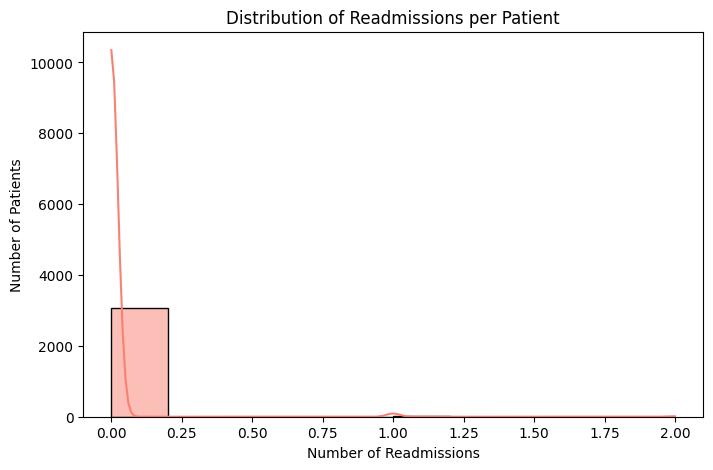

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(readmission_features['num_readmissions'], bins=10, color='salmon', kde=True)
plt.title('Distribution of Readmissions per Patient')
plt.xlabel('Number of Readmissions')
plt.ylabel('Number of Patients')
plt.show()


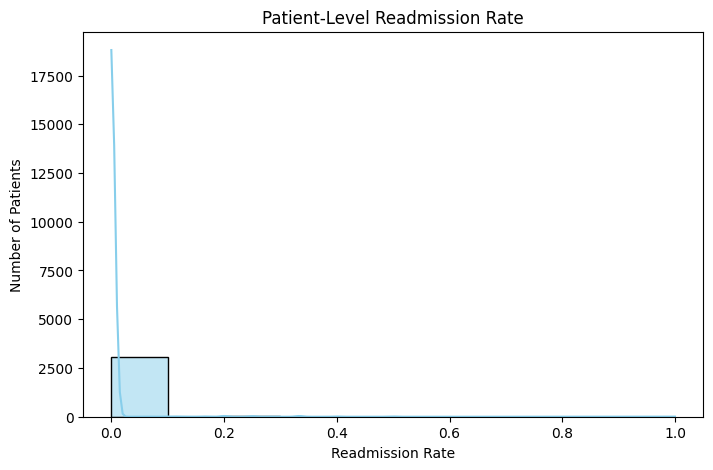

In [24]:
plt.figure(figsize=(8,5))
sns.histplot(readmission_features['readmission_rate'], bins=10, color='skyblue', kde=True)
plt.title('Patient-Level Readmission Rate')
plt.xlabel('Readmission Rate')
plt.ylabel('Number of Patients')
plt.show()


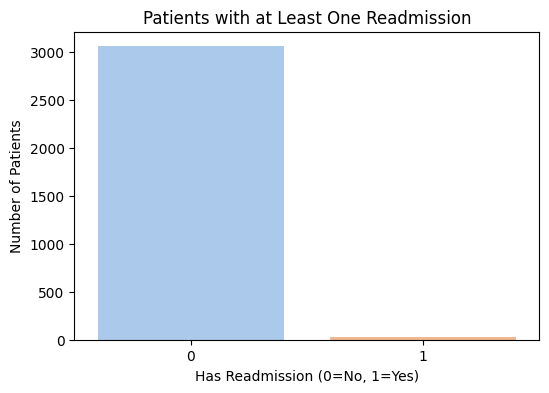

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(x=(readmission_features['num_readmissions'] > 0).astype(int), palette='pastel')
plt.title('Patients with at Least One Readmission')
plt.xlabel('Has Readmission (0=No, 1=Yes)')
plt.ylabel('Number of Patients')
plt.show()


In [26]:

visit_type_dummies = pd.get_dummies(visit_df['visit_type'], prefix='visit_type')


visit_df = pd.concat([visit_df, visit_type_dummies], axis=1)


visit_final = (
    visit_df.groupby('patient_id')
    .agg({
        'visit_id': 'count',  # total number of visits
        'visit_type_ER': 'sum',
        'visit_type_URGENT CARE': 'sum',
        'visit_type_INPATIENT': 'sum',
        'readmsn_ind': 'sum',
        'visit_start_dt': 'min', 
        'visit_end_dt': 'max',   
    })
    .reset_index()
)


visit_final.rename(columns={
    'visit_id': 'num_visits',
    'visit_type_ER': 'num_er_visits',
    'visit_type_URGENT CARE': 'num_urgent_visits',
    'visit_type_INPATIENT': 'num_inpatient_visits',
    'readmsn_ind': 'num_readmissions',
    'visit_start_dt': 'first_visit_dt',
    'visit_end_dt': 'last_visit_dt'
}, inplace=True)


visit_final['days_between_first_last_visit'] = (
    (visit_final['last_visit_dt'] - visit_final['first_visit_dt']).dt.days
)

print(visit_final.head())


   patient_id  num_visits  num_er_visits  num_urgent_visits  \
0          80           5              1                  4   
1          98           1              0                  1   
2         110           6              2                  4   
3         125           1              0                  1   
4         161           1              1                  0   

   num_inpatient_visits  num_readmissions first_visit_dt last_visit_dt  \
0                     0                 0     2023-12-23    2024-08-04   
1                     0                 0     2024-04-14    2024-04-14   
2                     0                 0     2023-08-30    2025-02-21   
3                     0                 0     2024-12-18    2024-12-18   
4                     0                 0     2024-02-08    2024-02-08   

   days_between_first_last_visit  
0                            225  
1                              0  
2                            541  
3                              0  
4

In [27]:
visit_final.head(3)

,patient_id,num_visits,num_er_visits,num_urgent_visits,num_inpatient_visits,num_readmissions,first_visit_dt,last_visit_dt,days_between_first_last_visit
0,80,5,1,4,0,0,2023-12-23,2024-08-04,225
1,98,1,0,1,0,0,2024-04-14,2024-04-14,0
2,110,6,2,4,0,0,2023-08-30,2025-02-21,541


In [28]:
visit_final.isnull().sum()

patient_id                       0
num_visits                       0
num_er_visits                    0
num_urgent_visits                0
num_inpatient_visits             0
num_readmissions                 0
first_visit_dt                   0
last_visit_dt                    0
days_between_first_last_visit    0
dtype: int64